In [1]:
#use torch=1.10.1 and torchvision=0.11.2
!pip install -U torch torchvision
!pip install timm

     |████████████████████████████████| 881.9 MB 10.0 kB/s            
     |████████████████████████████████| 23.3 MB 819 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
     |████████████████████████████████| 431 kB 289 kB/s            


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
import time
from tqdm import tqdm
import os

In [3]:
!tar -xvzf /kaggle/input/200-bird-species-with-11788-images/CUB_200_2011.tgz

attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split

In [5]:
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform

In [6]:
print(torch.__version__)
print(torchvision.__version__)

1.10.1+cu102
0.11.2+cu102


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
import numpy as np
from torchvision import models

In [9]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [10]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#             transforms.RandomErasing(p=0.25, value='random')
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.75)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data_len
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.70)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return (val_loader, test_loader, valid_data_len, test_data_len)

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
dataset_path = "CUB_200_2011/images/"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 256, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 64, train=False)
classes = get_classes(dataset_path)

In [13]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [14]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

35
28
28


In [15]:
print(train_data_len, test_data_len, valid_data_len)

8841 1769 1768


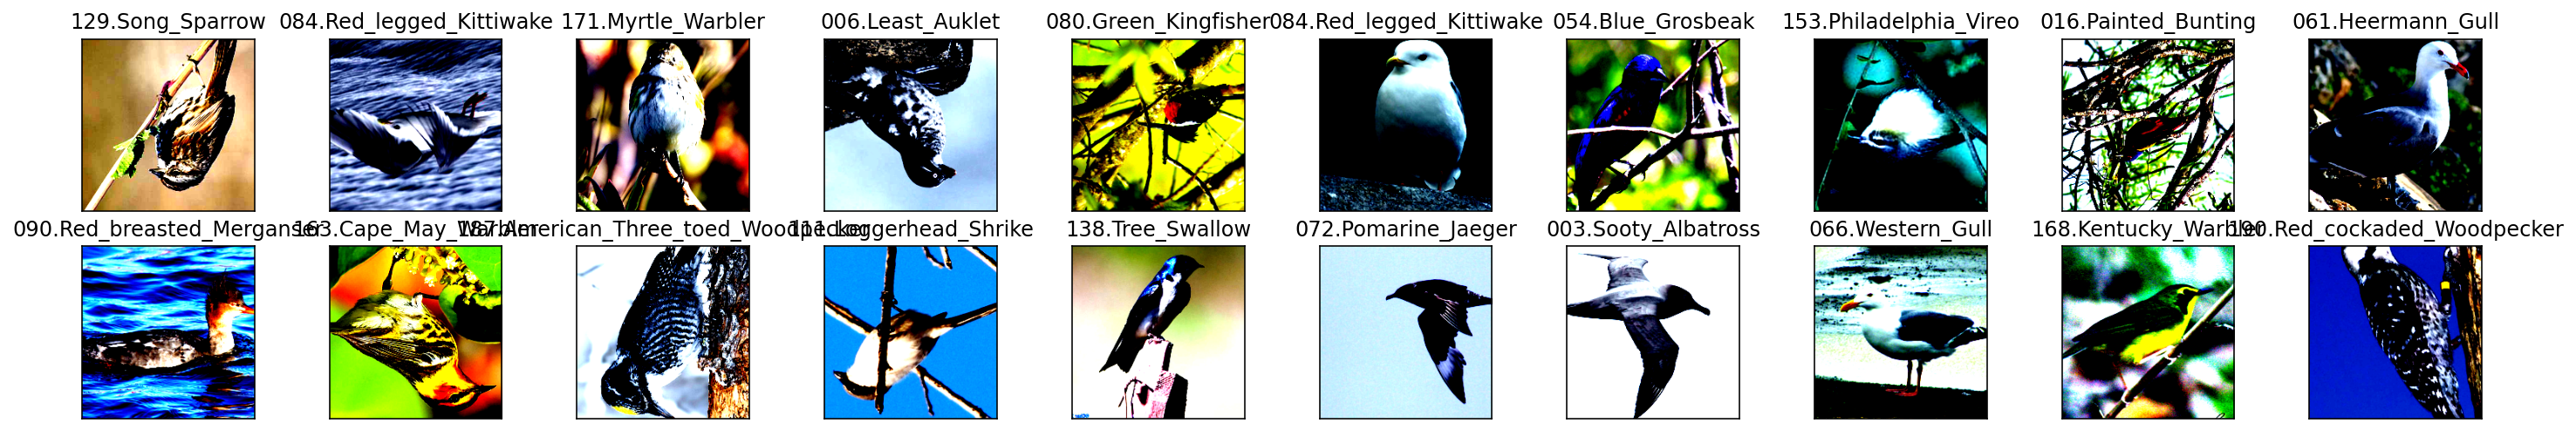

In [16]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
# model = torch.hub.load('facebookresearch/deit:main', 'resmlp_12', pretrained=True)
torch.backends.cudnn.benchmark = True
model = torchvision.models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=200, bias=True)
)


In [21]:
print(f"Trainable Params: {count_parameters(model)}")

Trainable Params: 3033288


In [22]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [23]:
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.96)

In [24]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model_ft = train_model(model, criterion, optimizer, step_scheduler,
                       num_epochs=11)

Epoch 0/10
----------


100%|██████████| 35/35 [00:57<00:00,  1.65s/it]


train Loss: 4.5489 Acc: 0.1887


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


val Loss: 3.4023 Acc: 0.4870

Epoch 1/10
----------


100%|██████████| 35/35 [00:56<00:00,  1.61s/it]


train Loss: 3.3422 Acc: 0.5002


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


val Loss: 2.8897 Acc: 0.6725

Epoch 2/10
----------


100%|██████████| 35/35 [00:56<00:00,  1.63s/it]


train Loss: 2.9747 Acc: 0.6280


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


val Loss: 2.6818 Acc: 0.7359

Epoch 3/10
----------


100%|██████████| 35/35 [00:58<00:00,  1.66s/it]


train Loss: 2.7838 Acc: 0.6952


100%|██████████| 28/28 [00:11<00:00,  2.39it/s]


val Loss: 2.5625 Acc: 0.7721

Epoch 4/10
----------


100%|██████████| 35/35 [00:57<00:00,  1.65s/it]


train Loss: 2.6510 Acc: 0.7478


100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


val Loss: 2.4600 Acc: 0.8235

Epoch 5/10
----------


100%|██████████| 35/35 [00:58<00:00,  1.66s/it]


train Loss: 2.5399 Acc: 0.7928


100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


val Loss: 2.4014 Acc: 0.8360

Epoch 6/10
----------


100%|██████████| 35/35 [00:57<00:00,  1.65s/it]


train Loss: 2.4497 Acc: 0.8225


100%|██████████| 28/28 [00:11<00:00,  2.39it/s]


val Loss: 2.3446 Acc: 0.8546

Epoch 7/10
----------


100%|██████████| 35/35 [00:57<00:00,  1.63s/it]


train Loss: 2.3738 Acc: 0.8476


100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


val Loss: 2.2977 Acc: 0.8569

Epoch 8/10
----------


100%|██████████| 35/35 [00:58<00:00,  1.66s/it]


train Loss: 2.3080 Acc: 0.8726


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


val Loss: 2.2722 Acc: 0.8563

Epoch 9/10
----------


100%|██████████| 35/35 [00:57<00:00,  1.64s/it]


train Loss: 2.2473 Acc: 0.8965


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


val Loss: 2.2283 Acc: 0.8795

Epoch 10/10
----------


100%|██████████| 35/35 [00:57<00:00,  1.63s/it]


train Loss: 2.2081 Acc: 0.9058


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


val Loss: 2.1928 Acc: 0.8874

Training complete in 12m 46s
Best val Acc: 0.887443


In [27]:
torch.cuda.empty_cache()

In [28]:
%%time
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model_ft.eval()

for data, target in tqdm(test_loader):
    if torch.cuda.is_available(): 
        data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

Test Loss: 2.202743

Test Accuracy of 001.Black_footed_Albatross: 80% ( 4/ 5)
Test Accuracy of 002.Laysan_Albatross: 91% (11/12)
Test Accuracy of 003.Sooty_Albatross: 100% ( 9/ 9)
Test Accuracy of 004.Groove_billed_Ani: 100% ( 9/ 9)
Test Accuracy of 005.Crested_Auklet: 100% ( 6/ 6)
Test Accuracy of 006.Least_Auklet: 100% ( 6/ 6)
Test Accuracy of 007.Parakeet_Auklet: 100% ( 8/ 8)
Test Accuracy of 008.Rhinoceros_Auklet: 100% ( 9/ 9)
Test Accuracy of 009.Brewer_Blackbird: 62% ( 5/ 8)
Test Accuracy of 010.Red_winged_Blackbird: 90% ( 9/10)
Test Accuracy of 011.Rusty_Blackbird: 63% ( 7/11)
Test Accuracy of 012.Yellow_headed_Blackbird: 100% ( 8/ 8)
Test Accuracy of 013.Bobolink: 90% (10/11)
Test Accuracy of 014.Indigo_Bunting: 88% ( 8/ 9)
Test Accuracy of 015.Lazuli_Bunting: 100% ( 7/ 7)
Test Accuracy of 016.Painted_Bunting: 100% ( 7/ 7)
Test Accuracy of 017.Cardinal: 100% ( 6/ 6)
Test Accuracy of 018.Spotted_Catbird: 100% ( 7/ 7)
Test Accuracy of 019.Gray_Catbird: 100% ( 8/ 8)
Test Accuracy 

In [29]:
from PIL import Image
from io import BytesIO
import requests

In [30]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [31]:
def predict(model, filepath, show_img=False, url=False):
    if url:
        response = requests.get(filepath)
        im = Image.open(BytesIO(response.content))
    else:
         im = Image.open(filepath)
    if show_img:
        plt.imshow(im)
    im_as_tensor = apply_test_transforms(im)
    minibatch = torch.stack([im_as_tensor])
    if torch.cuda.is_available():
        minibatch = minibatch.cuda()
    pred = model(minibatch)
    _, classnum = torch.max(pred, 1)
    print(classnum)
    return classes[classnum]

In [32]:
def formatText(string):
    string = string[4:]
    string = string.replace("-", " ")
    return string

tensor([95], device='cuda:0')


'Hooded_Oriole'

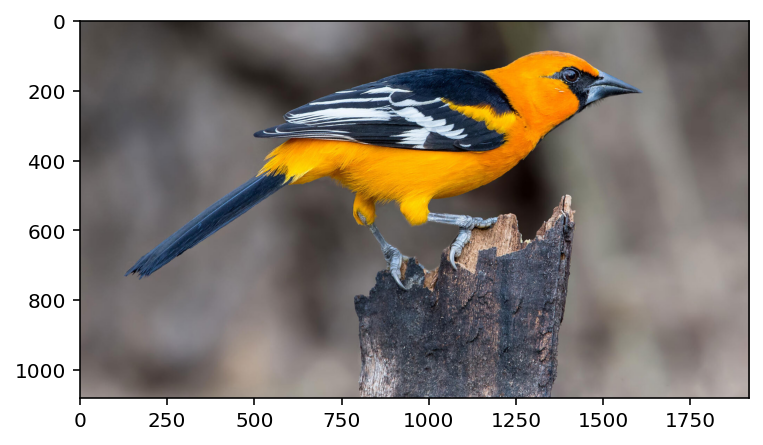

In [33]:
formatText(predict(model_ft, "https://www.audubon.org/sites/default/files/styles/hero_cover_bird_page/public/web_h_andy-morffew_flickr-creative-common-by-2.0_altamiraoriole_flickr-3-adult.jpg?itok=ad9rnLPN", show_img=True, url=True))

tensor([53], device='cuda:0')


'Blue_Grosbeak'

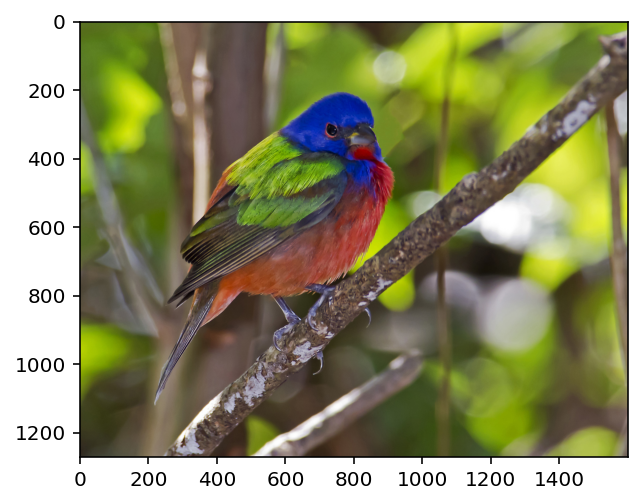

In [34]:
formatText(predict(model_ft, "https://cdn.birdwatchingdaily.com/2013/06/MalePaintedBunting.jpg", show_img=True, url=True))

tensor([115], device='cuda:0')


'Chipping_Sparrow'

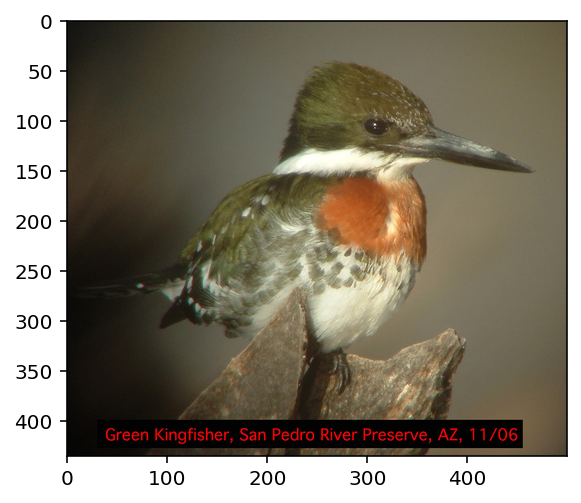

In [35]:
formatText(predict(model_ft, "CUB_200_2011/images/080.Green_Kingfisher/Green_Kingfisher_0027_71048.jpg", show_img=True))

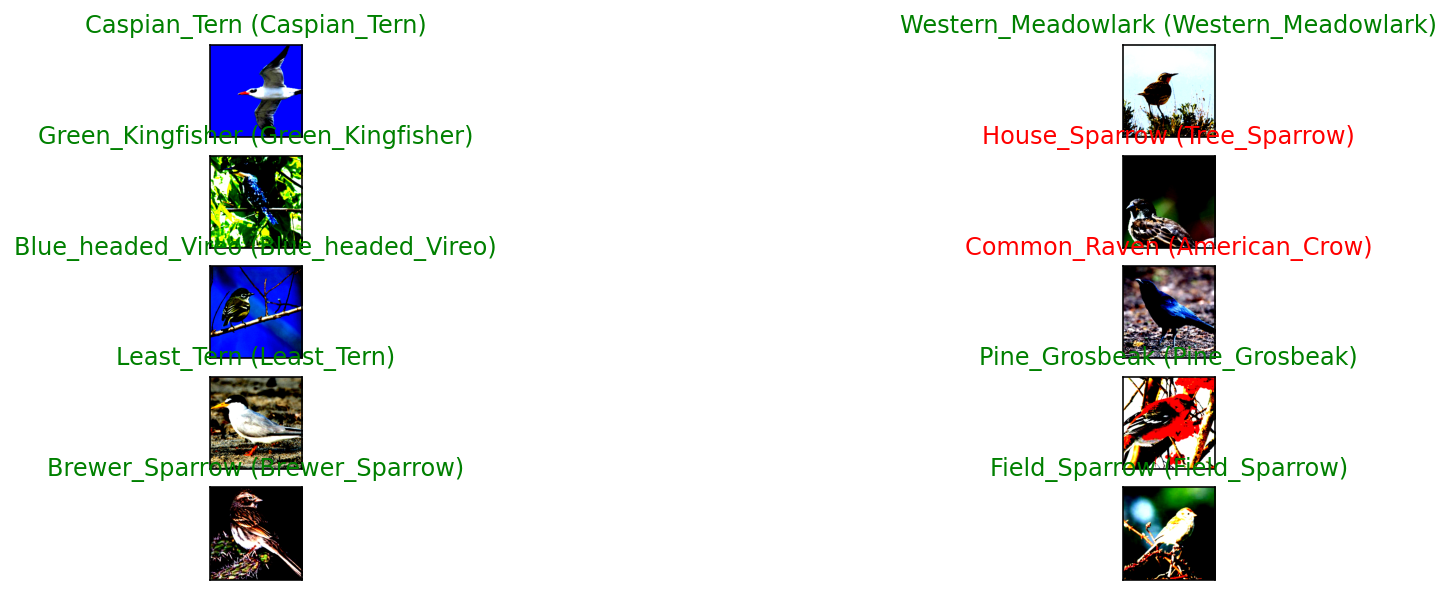

In [36]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model_ft(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 10))
for idx in np.arange(10):
    ax = fig.add_subplot(10, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(formatText(classes[preds[idx]]), formatText(classes[labels[idx]])),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [37]:
x = torch.randn(1, 3, 224, 224, requires_grad=False).to(device)

In [38]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_ft.cpu(), example)

In [39]:
traced_script_module.save("cub2011-deit-tiny.zip")